## SENEKAL

------------------------------------------------------
### POSITIONAL ANALYSIS


Positional analysis is the subfield of network science concerned with the identification of actors or groups of actors who occupy similar positions or roles based on some feature or structure of the network.



#### Data Source



*#Senekal Reply Network - Largest Component*


#### Data Transformation



Missing data are typically handled poorly by this type of clustering algorithm, therefore I exclude observations with any missing data from the feature dataset. Additionally, to standardise the data, I use a data scaling method called "MinMaxScaler" that is careful to not assume the shape of the selected features as normally distributed.


#### Method



Using pythons scikit-learn library, I present feature based techniques that detect optimal **k-means algorithm** clusters.


In [1]:
#
#import import_ipynb
#import os
import pandas as pd
import numpy as np
from scipy import stats
import igraph as ig
import matplotlib.pyplot as plt
import plotly.express as px
from operator import itemgetter
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from kneed import KneeLocator
import random
from numpy import random as nprando
from IPython.display import Image, SVG, display

#########################################################################################

##SETUP##
sns.set()
nprando.seed(111)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (12, 8)})
pd.set_option("display.max_columns",None)

##FUNCTIONS##
# Independent Cascade Model
def ic(G,s,d=[], a=[]):
    #print(s)
    jst_inf=list(s)
    infected=list(s)
    #flag = True
    while(1):
        #print(jst_inf, infected)
        # iteration ends when jst_infected list becomes empty
        if len(jst_inf)==0:
            return infected
            #flag = False
        tmp=[]
        for each in jst_inf:
            for each1 in G.neighbors(each, mode='all'):
                r = random.uniform(0,1)
                # if node in spreader role, do not infect node
                if each1 in d:
                    r=0
                # if node in activist role, do not infect node
                if each1 in a:
                    r=0    
                # if node has random number less than 0.5, infect node
                if r>0.5 and each1 not in infected and each1 not in tmp:
                    tmp.append(each1)
            # overall infected nodes
            infected.append(each)
        # infected nodes in current iteration
        jst_inf=list(tmp)

##VARIABLES##
e_feat = "senekal_features_1.csv"
range_1 = range(2,30)
range_2 = range(2,30)
n_clust = 10
clust_sel = [[9,6,7,8,4],[9,6,8,4]]

#########################################################################################

##LOAD DATA##
df_sen_1 = pd.read_csv(e_feat, sep=";", dtype={'id': str})
#df_sen_1.describe()  

# Drop data with missing observations
# Typically would impute missing data however this is data of users who did not tweet once in the dataset however were replied to 
df_null_1 = df_sen_1[df_sen_1.isna().any(axis=1)]
df_null_1.describe()
df_sen_1 = df_sen_1.dropna()
df_sen_1.reset_index(inplace=True)
#df_sen_1.describe() #changes are less than std increase to mean


-----------------------------------------------------------
#### 1. SELECTION


###### Feature Correlation

The 16 features selected for this analysis are detailed in the Part I: Descriptive Analysis. They cover node attributes of expansiveness (whether someone is a social butterfly or wallflower), attractiveness (whether someone is popular or unpopular), as well as relevance (whether someone is locally important or important gloably). For example, a person can be generally active on social media with a high number of tweets, while another person can be active with a high number of tweets at one particular point in time discussing one particular issue. Both of these traits are captured by the features: *tweets* (global) and *#tweeted* (local).

Notable observations from the correlation matrix:  

- being *listed* on a public list is positively correlated with the number of *followers*.

- *#tweeted*, *#liked* and *#retweeted* are positively correlated with the *indegree* of tweets being replied to as well as the *pagerank* likelihood of being connected to other high rank positions.

- *reciprocity*, *transitivity*, *hierarchy* are all positively correlated with the *outdegree* of replying to tweets.




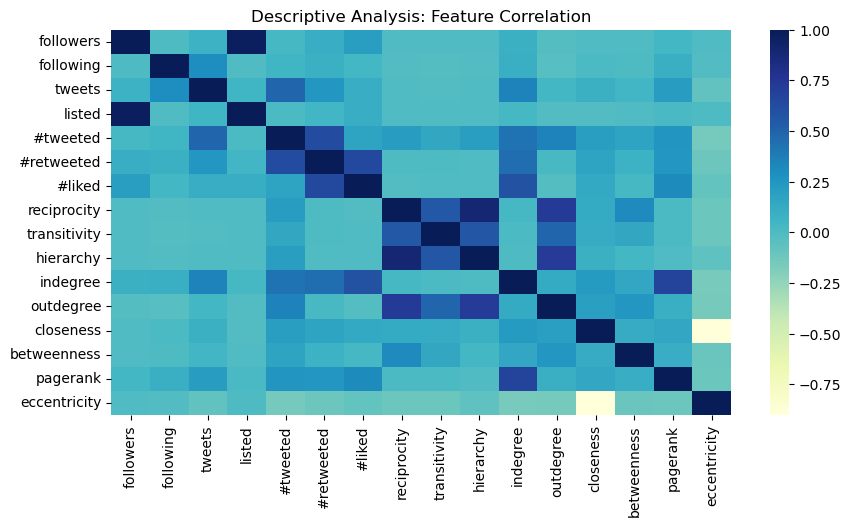

In [2]:
#
# K-MEANS CLUSTERING

feat_cols = ['followers', 'following','tweets','listed','#tweeted','#retweeted','#liked','reciprocity','transitivity','hierarchy', 'indegree', 'outdegree', 'closeness', 'betweenness', 'pagerank', 'eccentricity']
df_feat = df_sen_1.loc[:,feat_cols]

df_corr = df_feat
feat_corr = df_corr.corr()
plt.rcParams["figure.figsize"]=[10,5]
sns.heatmap(feat_corr, annot = False, cmap='YlGnBu')
plt.title('Descriptive Analysis: Feature Correlation')
#plt.savefig("{}".format(gpath) + x + "_feature_correlation_wr.png")
plt.show()

In [3]:
#
# DATA TRANSFORMATION
# Impute missing data
#imputer = KNNImputer(n_neighbors=3)
#imputer.fit_transform(df_feat)

# Standardizing the data
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_feat)

# The StandardScaler class implements a type of feature scaling called standardization. Standardization scales, or shifts, the values for each numerical feature in your dataset so that the features have a mean of 0 and standard deviation of 1
# The pipeline will implement an alternative to the StandardScaler class called MinMaxScaler for feature scaling. 
# You use MinMaxScaler when you do not assume that the shape of all your features follows a normal distribution.
# An alternative to the StandardScaler class called MinMaxScaler for feature scaling. 
# You use MinMaxScaler when you do not assume that the shape of all your features follows a normal distribution.

# Statistics of scaled data
#pd.DataFrame(scaled_feat).describe()

-------------------------------------------------------
#### 2. DETECTION


Using k-means clustering techniques, I detect the optimal number of clusters to fit the network data.



#### 2.1. The Elbow Method

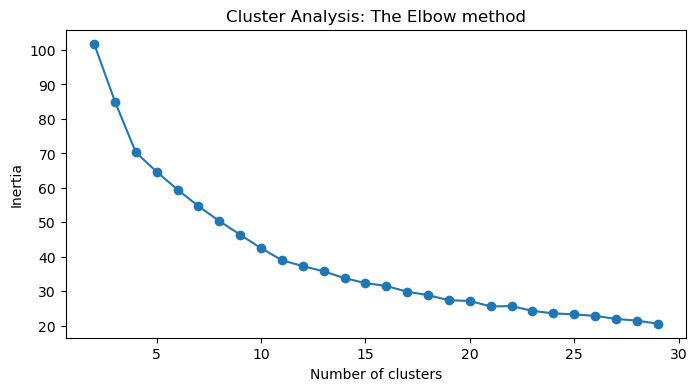

In [4]:
#
# CLUSTER DETECTION
# The Elbow method is the most popular in finding an optimum number of clusters, this method uses WCSS (Within Clusters Sum of Squares) which accounts for the total variations within a cluster.
# Elbow curve, where the x-axis will represent the number of clusters and the y-axis will be an evaluation metric. Let’s say inertia for now.
# You can choose any other evaluation metric like the Dunn index as wel
# Defining the kmeans function with initialization as k-means++
# Fitting multiple k-means algorithms and storing the values in an empty list

#range_1 = range(2,30)
#range_2 = range(2,30)

WCSS=[]
for cluster in range_1:
    kmeans = KMeans(n_clusters=cluster, init='k-means++')
    kmeans.fit(scaled_feat)
    wcss_iter = kmeans.inertia_ 
    WCSS.append(wcss_iter)

# Converting the results into a dataframe and plotting them
# The quality of the cluster assignments is determined by computing the sum of the squared error (SSE) after the centroids converge, or match the previous iteration’s assignment. 
# The SSE is defined as the sum of the squared Euclidean distances of each point to its closest centroid. 
# Since this is a measure of error, the objective of k-means is to try to minimize this value
frame = pd.DataFrame({'Cluster':range_1,'WCSS':WCSS})
plt.rcParams["figure.figsize"]=[8,4]
#plt.rcParams["figure.autolayout"] =True
plt.plot(frame['Cluster'], frame['WCSS'], marker='o')
plt.title('Cluster Analysis: The Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
#plt.savefig("{}".format(gpath) + x + "_cluster_elbow_wr.png")
plt.show()

# As the number of clusters increases, the variance (within-cluster sum of squares) decreases. 

**KneeLocator**

Since it is not visibly clear, just by looking, which point of the curve is the knee or point of the maximum curvature. I run the *kneelocator* function and find the optimum number of clusters at k-cluster=11.

In [5]:
#
#Find the knee or point of curve (point of maximum curvature)
kl = KneeLocator(range_1, WCSS, curve="convex", direction="decreasing")
kl.elbow

11

#### 2.2. The Silhouette Method


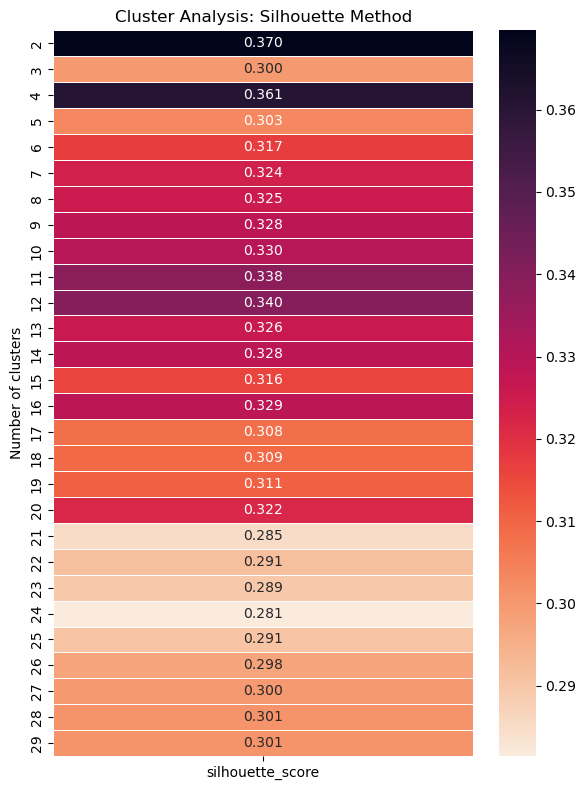

In [6]:
#
#SILHOUETTE METHOD
#The silhouette coefficient is a measure of cluster cohesion and separation. 
#It quantifies how well a data point fits into its assigned cluster based on two factors:
#1.How close the data point is to other points in the cluster
#2.How far away the data point is from points in other clusters
#Silhouette coefficient values range between -1 and 1. 
#Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range_2:
    kmeans = KMeans(init='k-means++',n_clusters=k, n_init=100, random_state=0)
    kmeans_labels = kmeans.fit_predict(scaled_feat)
    silhouette_avg = silhouette_score(scaled_feat, kmeans_labels)
    silhouette_coefficients.append([k,silhouette_avg])

result = pd.DataFrame(silhouette_coefficients, columns=["n_clusters","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

plt.rcParams.update({'figure.figsize': (6, 8)})
#plt.rcParams["figure.autolayout"] =True
plt.figure()
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.title('Cluster Analysis: Silhouette Method')
plt.ylabel('Number of clusters')
plt.tight_layout()
#plt.savefig("{}".format(gpath) + x + "_cluster_silhouette_wr.png")
plt.show()

The highest silhouette score obtained for k-clusters between 2 and 30 is 0.370 at k-cluster=2.

---------------------------------------------------
####  3. CLASSIFICATION



Using the elbow and silhouette method as a guide, I narrow the range of k-clusters and carefully examine the partitions that display the most consisent and meaningful result. I find k-cluster=7 and k-cluster=10 to have the best fit for this network data. 

I classify the different clusters by plotting the mean scores of each feature in a cluster and comparing them to the mean scores of features in other clusters. Distinct clusters are identified by the features that display the largest deviation from the mean score.


#### 3.1. Mean Score Plots

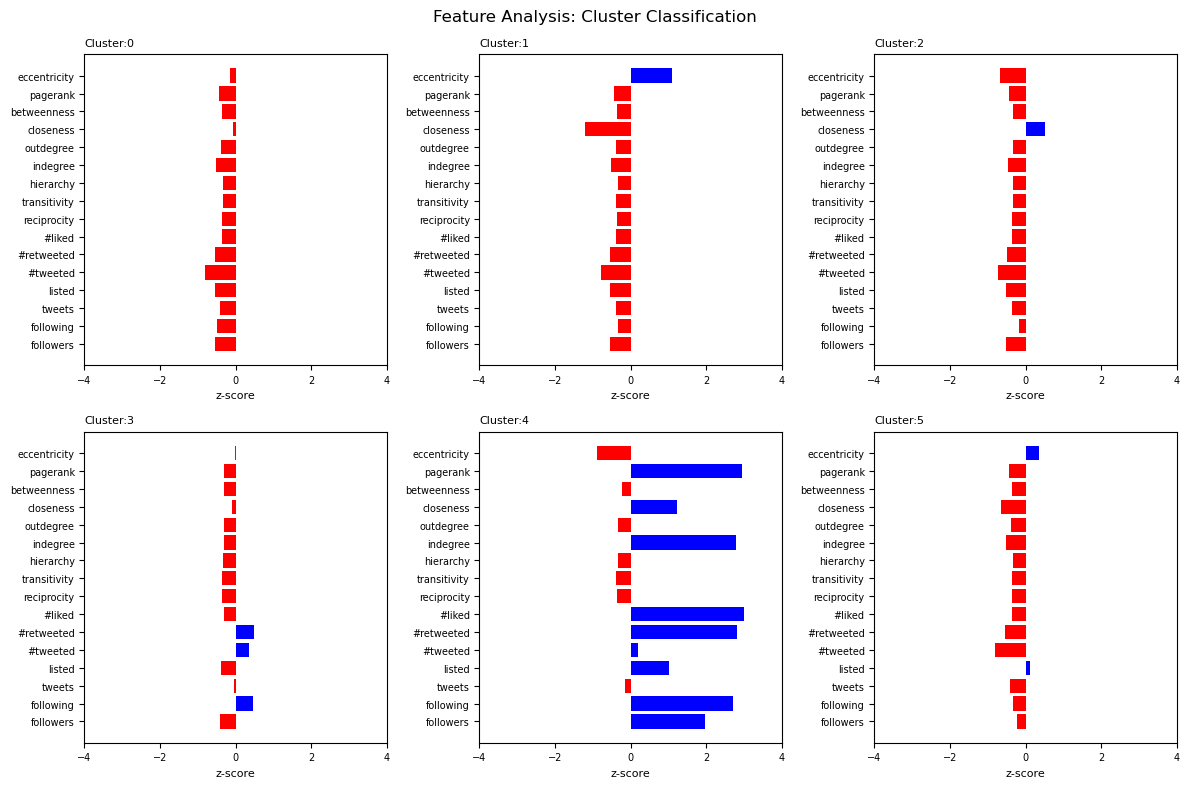

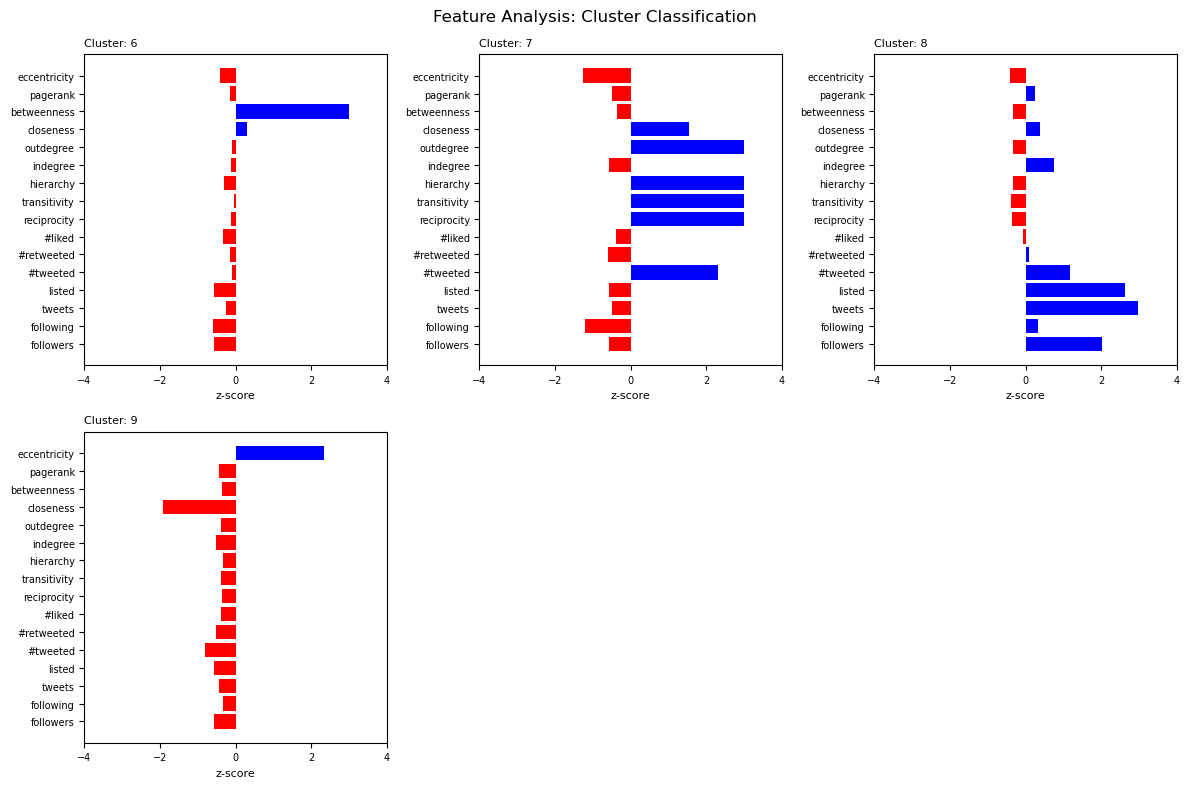

In [7]:
#
# CLUSTER CLASSIFICATION MEAN-SCORE PLOTS
#n_clust = 10      
kmeans_sel = KMeans(init='k-means++', n_clusters=n_clust, n_init=100, random_state=1).fit(scaled_feat)
labels = pd.DataFrame(kmeans_sel.labels_)
df_clust = df_sen_1.assign(Cluster=labels)

# Calculate cluster means and zscores
kmeans_clust = df_clust.groupby(['Cluster']).mean()
#print(kmeans_clust)
df_zmean_clust= kmeans_clust.loc[:,feat_cols].apply(stats.zscore)
df_zmean_clust.reset_index(inplace=True)
#print(df_zmean_clust)

# Plot grouped feature bar charts
def feature_plots(df, n_clusters):
    plt.rcParams["figure.figsize"]=[12,8]
    #plt.rcParams["figure.autolayout"] =True
    plot_range =[range(0,6),range(6,12)]
    c= (n_clusters//6)+1
    for r in range(0,c):
        for i in plot_range[r]:
            if i < n_clusters:
                x_cols = df.loc[:,feat_cols].values.tolist()[i]
                col=[]
                for val in x_cols:
                    if val < 0:
                        col.append('red')
                    else:
                        col.append('blue')

                y = feat_cols
                x = list(x_cols)

                if i in plot_range[0]:
                    n='a'
                    plt.subplot(2,3,i+1)
                    plt.title("Cluster:"+str(i), fontsize=8, loc='left')
                elif i in plot_range[1]:
                    n='b'
                    i_2 = i-6
                    plt.subplot(2,3,i_2+1)
                    plt.title("Cluster: "+str(i), fontsize=8, loc='left')

                plt.xlim(-4,4)
                plt.barh(y,x, color=col)
                plt.yticks(fontsize=7)
                plt.xticks(fontsize=7)
                plt.xlabel('z-score', fontsize=8)

        plt.suptitle('Feature Analysis: Cluster Classification')
        plt.tight_layout()
        #plt.savefig("{}".format(gpath) + x + "_cluster_feature_wr_" + n + ".png")
        plt.show()

feature_plots(df_zmean_clust, n_clust)


At k-cluster=10, 5 distinct clusters are detected. The remaining 5 exhibit non-distinct or low value features. Non-disinct clusters are therefore labelled as **Minor** types, while the 5 distinct clusters are labelled as such:

1. **Observer** -> periphery users that are far away from the centre of the discourse and have little participation or involvement.


2. **Spreader** -> bridge users that are connected to users in various positions and can easily spread information across the network.


3. **Activator** -> active users that reply to tweets and have a high interaction and engagement with other users.


4. **Informer** -> public users that have many followers, are publicly listed and have a high global tweet count.


5. **Leader** -> popular users that receive many replies to tweets and interact mainly with other users of similar status.

At k-cluster=7 (not displated), 3 distinct positions are well detected. These are basically the same as above, except that the *Activator* and *Spreader* types form a combined cluster, and so do the *Informer* and *Leader* types:

1. **Observer**


2. **Activator + Spreader**


3. **Informer + Leader** 

Due to the significant outlier features exhibited by the **Tranced6** user skewing the partitions found at k-cluster=7, I proceed with k-cluster=10 to avoid biasing the results. 

Below, I list the cluster sizes and usernames of members assigned to each distinct cluster group. I also re-plot the mean scores to include only the disctinct clusters. 

In [8]:
#
# CLUSTER DESCRIPTION
# calculate cluster sizes
df_g_clust = df_clust[['id','Cluster']]
print("\n" + "--------" + "\n" + '\033[1m' + "K-Cluster Sizes:")
print("------------------------" + "\n")
print(df_g_clust.groupby('Cluster').count())
print("------------------------")
# Not surprising that there is large variation in cluster weight. Certain roles of (e.g. roles authority) are in the form of hierarchal structures. 


--------
K-Cluster Sizes:
------------------------

          id
Cluster     
0        591
1        365
2        232
3         88
4          6
5        633
6         13
7          1
8         12
9         76
------------------------


In [9]:
#
#Cluster 9
print("\n" + "--------" + "\n" + '\033[1m' + "K-Cluster Types:")
print("------------------------")
df_c6 =df_clust.loc[df_clust['Cluster']==clust_sel[0][0]]
print("\n" + "--------" + "\n" + '\033[1m' + 'Cluster ' + str(clust_sel[0][0]) + ': Observer' + '\033[0m')
print("--------"+ "\n")
#print(df_c6.loc[:,['id']].reset_index(drop=True).count())
print("List too large to display")
print("\n" + '\033[1m' + 'Features: +ve eccentricity and -ve closeness' + '\033[0m')
print("------------------------")


--------
K-Cluster Types:
------------------------

--------
Cluster 9: Observer
--------

List too large to display

Features: +ve eccentricity and -ve closeness
------------------------


In [10]:
#
#Cluster 6
#print("\n" + "--------" + "\n" + '\033[1m' + "K-Cluster Types:")
df_clust.sort_values(['betweenness'], inplace=True, ascending=False)
df_c6 =df_clust.loc[df_clust['Cluster']==clust_sel[0][1]]
print("\n" + "--------" + "\n" + '\033[1m' + 'Cluster ' + str(clust_sel[0][1]) + ': Spreader' + '\033[0m')
print("--------"+ "\n")
print(df_c6.loc[:,['label']].reset_index(drop=True))
print("\n" + '\033[1m' + 'Features: +ve betweenness' + '\033[0m')
print("------------------------")


--------
Cluster 6: Spreader
--------

             label
0        N_I_C_S_A
1      lilanichlsn
2      _Calculator
3       philcraig2
4     SaaymanBarry
5     PeterDermauw
6       ConCaracal
7       UnmovedLee
8          Dijosti
9   Teboho41703390
10     JohnWeak077
11   Ricky_ting777
12      ghandagand

Features: +ve betweenness
------------------------


In [11]:
#
#Cluster 7
#print("\n" + "--------" + "\n" + '\033[1m' + "K-Cluster Types:")
#print("--------")
df_clust.sort_values(['outdegree','hierarchy','transitivity','reciprocity','#tweeted'], inplace=True, ascending=False)
df_c7=df_clust.loc[df_clust['Cluster']==clust_sel[0][2]]
print("\n" + "--------" + "\n" + '\033[1m' + 'Cluster ' + str(clust_sel[0][2]) + ': Activator' + '\033[0m')
print("--------"+ "\n")
print(df_c7.loc[:,['label']].reset_index(drop=True))
print("\n" + '\033[1m' + 'Features: +ve outdegree, hierarchy, transitivity, reciprocity, #tweeted' + '\033[0m')
print("------------------------")
print('*Table list sorted by feature values.')


--------
Cluster 7: Activator
--------

      label
0  Tranced6

Features: +ve outdegree, hierarchy, transitivity, reciprocity, #tweeted
------------------------
*Table list sorted by feature values.


In [12]:
#
##### Cluster 8
#print("\n" + "--------" + "\n" + '\033[1m' + "K-Cluster Types:")
#print("--------")
df_clust.sort_values(['tweets', 'listed', 'followers'], inplace=True, ascending=False)
df_c8 = df_clust.loc[df_clust['Cluster']==clust_sel[0][3]]
print("\n" + "--------" + "\n" + '\033[1m' + 'Cluster ' + str(clust_sel[0][3]) + ': Informer' + '\033[0m')
print("--------"+ "\n")
print(df_c8.loc[:,['label']].reset_index(drop=True))
print("\n" + '\033[1m' + 'Features: +ve tweets, listed, followers*' + '\033[0m')
print("------------------------")
print('*Table list sorted by feature values.')


--------
Cluster 8: Informer
--------

             label
0     ntsikimazwai
1         SABCNews
2     Unathi_Kwaza
3         ALETTAHA
4   SABreakingNews
5             eNCA
6           News24
7         JacaNews
8              IOL
9       ewnupdates
10       TimesLIVE
11     ewnreporter

Features: +ve tweets, listed, followers*
------------------------
*Table list sorted by feature values.


In [13]:
#
#Cluster 4
#print("\n" + "--------" + "\n" + '\033[1m' + "K-Cluster Types:")
#print("--------")
df_clust.sort_values(['pagerank', 'indegree', '#liked', '#retweeted', 'following','followers'], inplace=True, ascending=False)
df_c4=df_clust.loc[df_clust['Cluster']==clust_sel[0][4]]
print("\n" + "--------" + "\n" + '\033[1m' + 'Cluster ' + str(clust_sel[0][4]) + ': Leader' + '\033[0m')
print("--------"+ "\n")
print(df_c4.loc[:,['label']].reset_index(drop=True))
print("\n" + '\033[1m' + 'Features: +ve pagerank, indegree, #liked, #retweeted, following, followers*' + '\033[0m')
print("------------------------")
print('*Table list sorted by feature values.')


--------
Cluster 4: Leader
--------

             label
0           Our_DA
1     PieterDuToit
2       ErnstRoets
3   EFFSouthAfrica
4  MbuyiseniNdlozi
5  Julius_S_Malema

Features: +ve pagerank, indegree, #liked, #retweeted, following, followers*
------------------------
*Table list sorted by feature values.


#### 3.2. Mean Score Plots (excl. Minor)

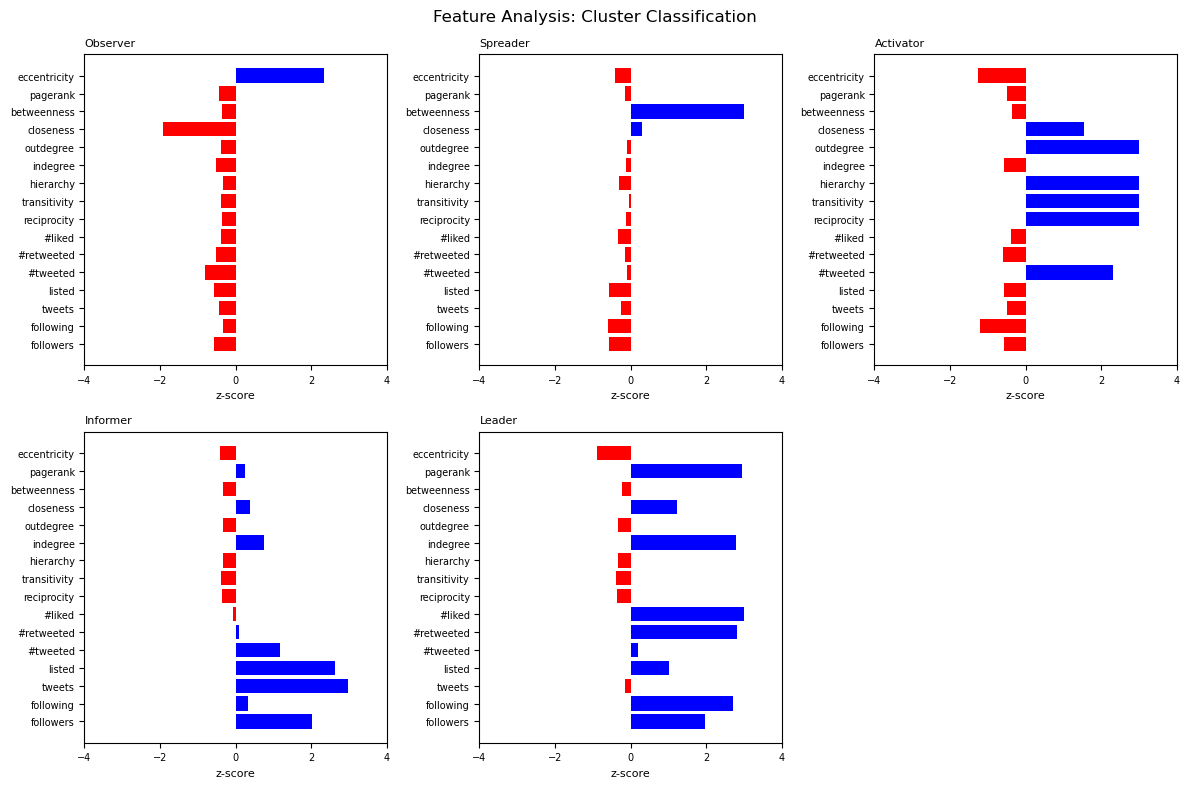

In [14]:
#
# CLUSTER CLASSIFICATION: MEAN-SCORE PLOTS
#clust_sel = [[9,6,7,8,4],[9,6,4]]
df_clust.sort_values(['index'], inplace=True, ascending=True)
# Identified a minimum of 5 distinct roles based on features consistent with positional characteristics of other networks

def cluster_type_5(value):
    if value == clust_sel[0][0]:
        return "Observer"
    elif value == clust_sel[0][1]:
        return "Spreader"
    elif value == clust_sel[0][2]:
        return "Activator"
    elif value == clust_sel[0][3]:
        return "Informer"
    elif value == clust_sel[0][4]:
            return "Leader"
    else:
        return "Minor"
    
    
# Add position category to dataframe
for c in clust_sel:
    if len(c) == 5:
        df_clust['Position_5'] = df_clust.apply(lambda row: cluster_type_5(row['Cluster']), axis=1)
        df_zmean_clust['Position_5'] = df_zmean_clust.apply(lambda row: cluster_type_5(row['Cluster']), axis=1)
df_clust.to_csv("senekal_kmeans_1.csv", sep=";",encoding='utf-8',  index=False)
#print(df_clust.info())	
#print(df_zmean_clust.info())


def feature_sel_plots(df, clusters):
    #plt.rcParams["figure.autolayout"] =True
    plt.rcParams["figure.figsize"]=[12,8]
    clust_range =[range(0,6),range(6,12)]
    c= (len(clusters)//6)+1
    for r in range(0,c):
        for i in clust_range[r]:
            if i < len(clusters):
                x_cols = df.loc[:,feat_cols].values.tolist()[clusters[i]]
                x_rol = df[df['Cluster']==clusters[i]]
                role = x_rol.Position_5.item()  
                col=[]
                for val in x_cols:
                    if val < 0:
                        col.append('red')
                    else:
                        col.append('blue')

                y = feat_cols
                x = list(x_cols)

                plt.subplot(2,3,i+1)
                #plt.title("Cluster:"+str(clusters[i]), fontsize=8, loc='left')
                plt.title(role, fontsize=8, loc='left')

            plt.xlim(-4,4)
            plt.barh(y,x, color=col)
            plt.yticks(fontsize=7)
            plt.xticks(fontsize=7)
            plt.xlabel('z-score', fontsize=8)

        plt.suptitle('Feature Analysis: Cluster Classification')
        plt.tight_layout()
        #plt.savefig("{}".format(gpath) + x + "_cluster_type_wr_.png")
        #plt.savefig("{}".format(gpath) + x + "_cluster_type_wr_.pdf")
        plt.show()

feature_sel_plots(df_zmean_clust, clust_sel[0])

--------------------------------------------
#### 4. EVALUATION



Using pythons seaborn library, I plot the pairwise relationships of detected clusters to assess the fit of nodes within a cluster and the relationships between nodes and their features. 

To interpret the results, lets say we want to consider the relationship between a node's distance from other nodes in the network and the probability of being added to a public list. From the plot, this can be found where the *closeness* feature on the y-axis meets the *listed* feature on the x-axis. Here, we can see that nodes in the *Informer* cluster share a positive relationship with being publicly listed and being close to other nodes in the network. Alternatively, if you are interested in the relationship between *indegree* and *pagerank*, then you would find the *pagerank* of interacting with high status users and the *indegree* of users tweets being replied to positively related to *Leader* type nodes. Additionally, when observing *reciprocity* and *outdegree* features, no significant relationships appear in any other groups except for the *Activator* group, shown by single green node in the top right corner that represents the **Tranced6** user account. 


In the next plot, I exclude possible outliers by removing the *Activator* role. I find the *Spreader* cluster more pronounced when comparing the *outdegree* of replying to tweets and the *reciprocity* of a mutual response.

#### 4.1. Pairwise Relationship Plots

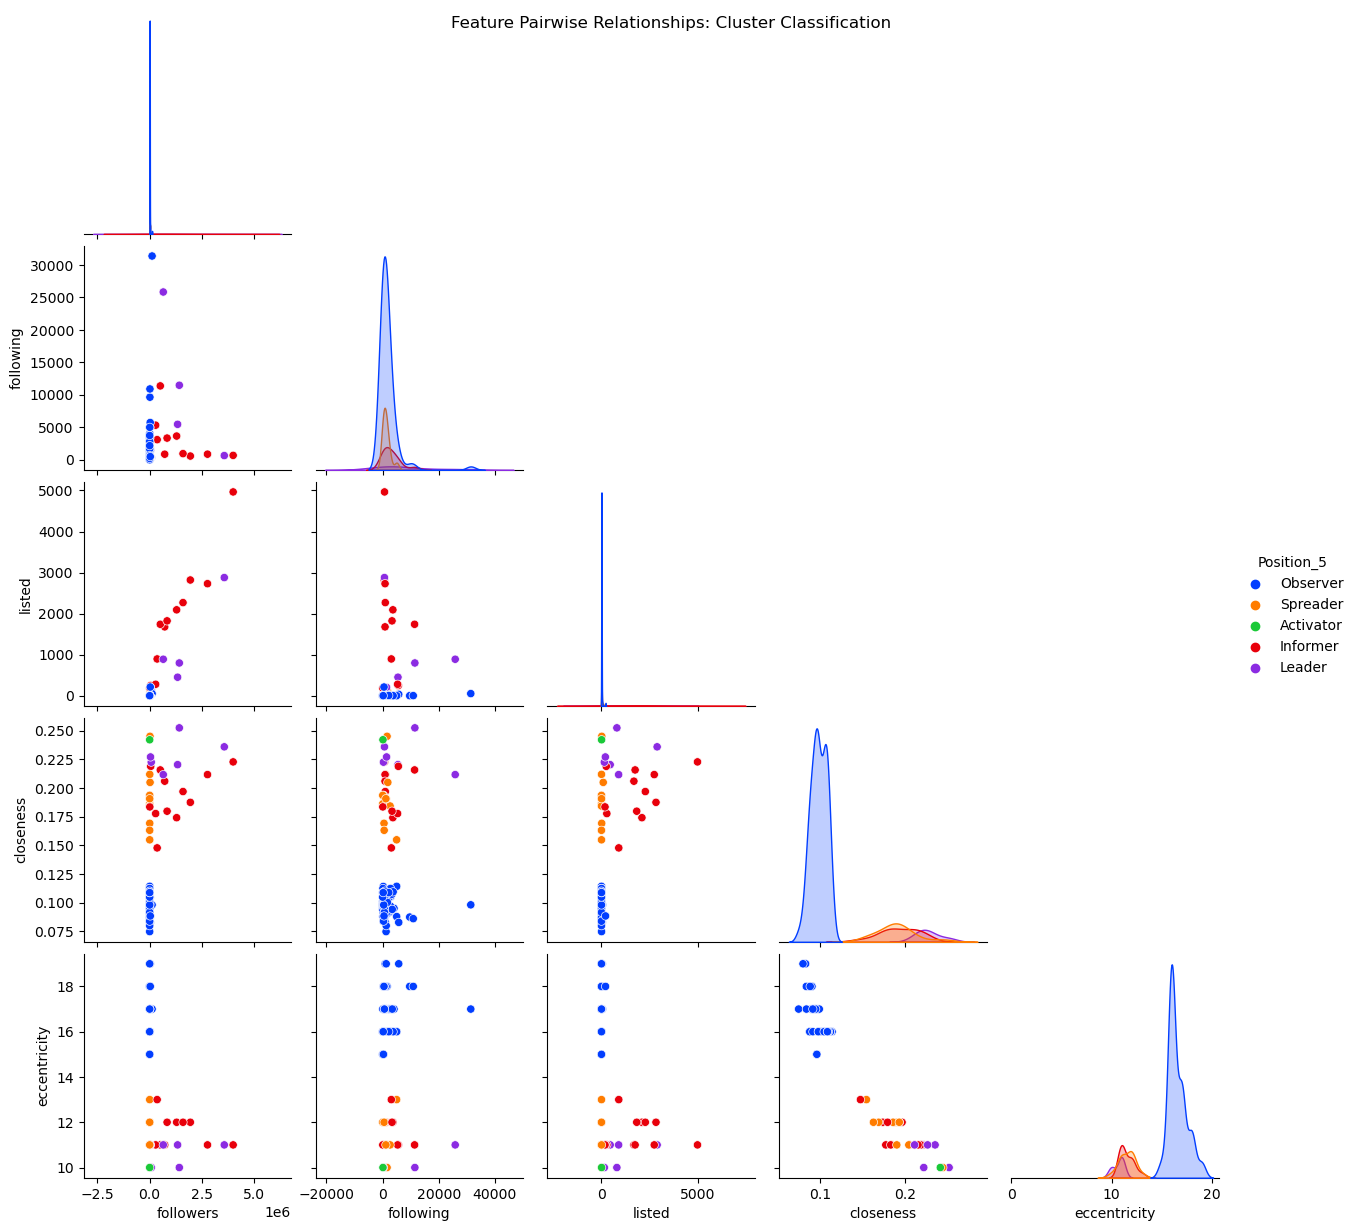

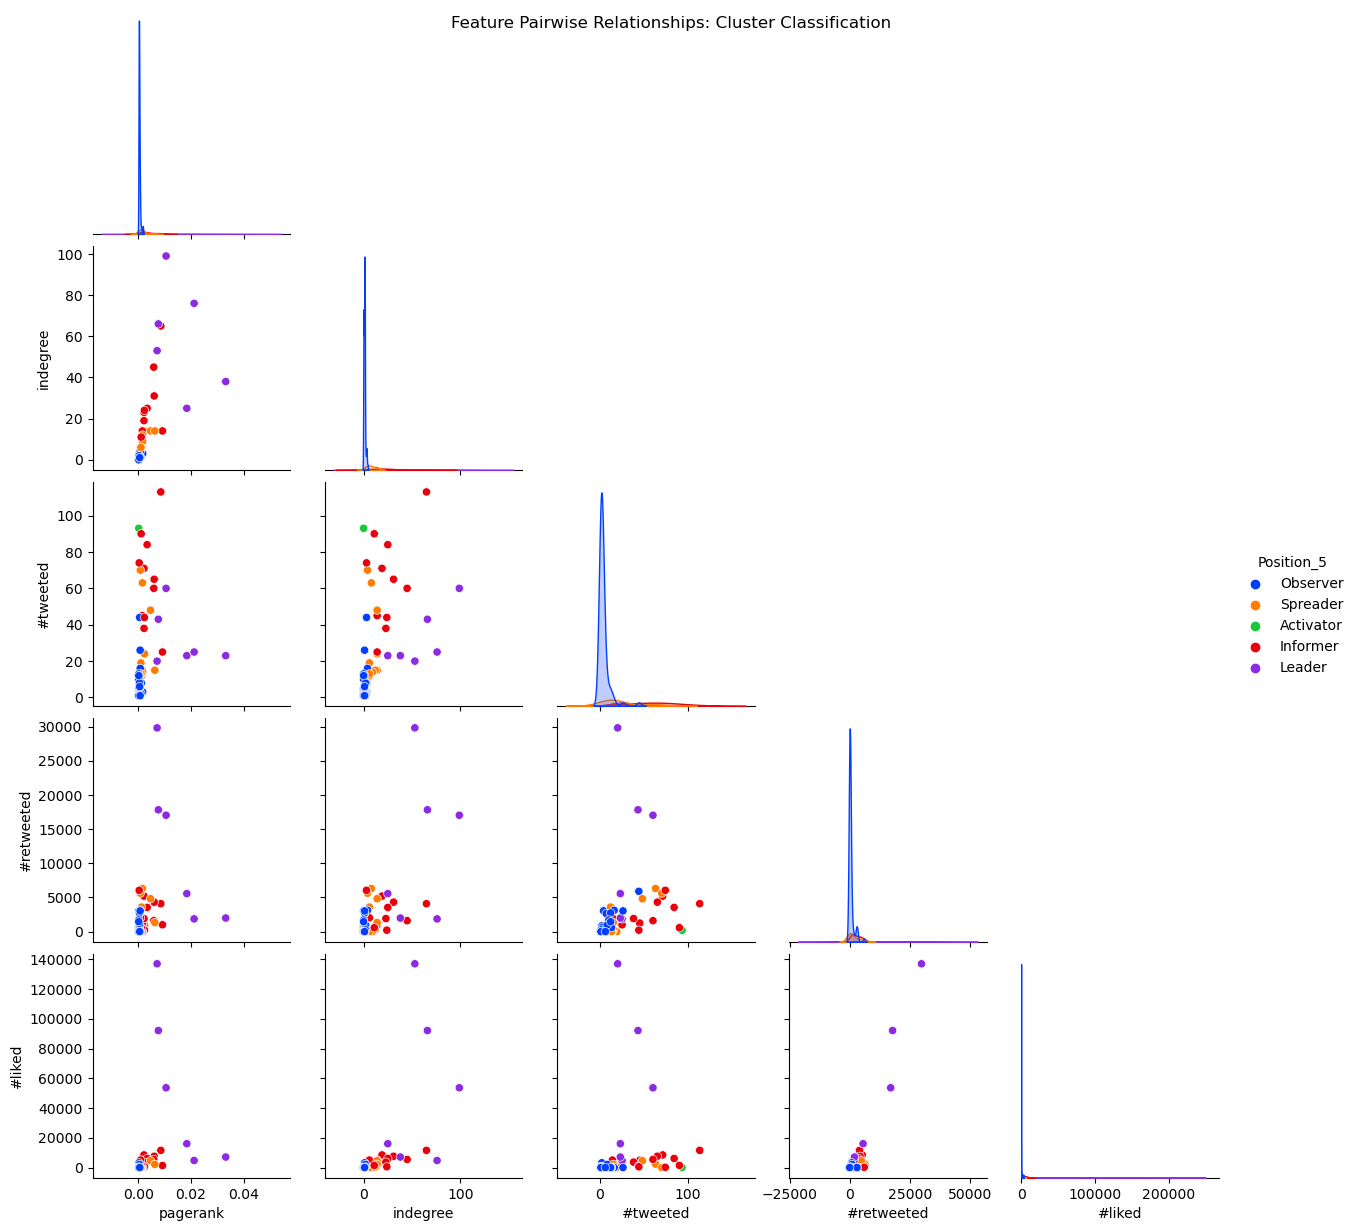

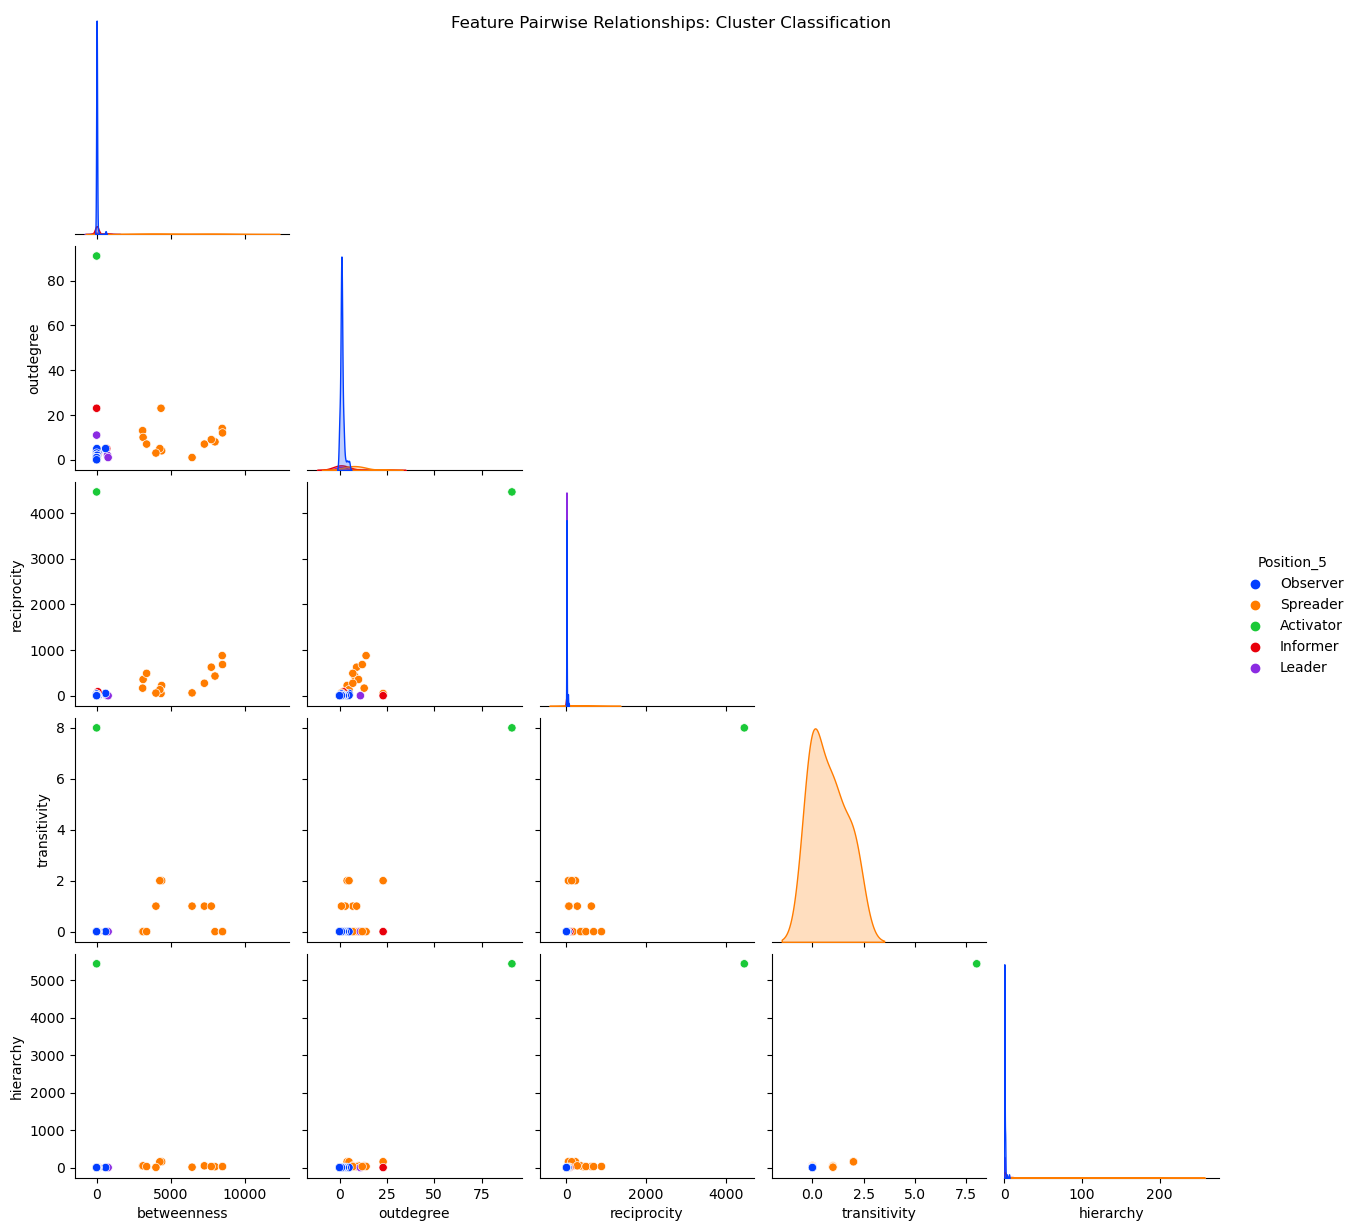

In [15]:
#
# CLUSTER CLASSIFICATION PAIRWISE PLOTS
feat_dict = {
        'a':['followers','following','listed', 'closeness', 'eccentricity'],
        'b':['pagerank','indegree', '#tweeted','#retweeted','#liked'],
        'c':['betweenness','outdegree','reciprocity','transitivity','hierarchy']
        }

#Graph with maximum limit of unique clusters
for c in clust_sel:
    if len(c) == 5 :

        clust_role=["Observer","Spreader","Activator","Informer","Leader"]

        for k,v in feat_dict.items():

            plt.rcParams["figure.autolayout"] =True
            plt.rcParams["figure.figsize"]=[8,8]
            sns.pairplot(df_clust.loc[df_clust['Cluster'].isin(c)],hue='Position_5',hue_order=clust_role,vars=v,palette=sns.color_palette('bright',len(clust_role)), corner=True)
            plt.suptitle('Feature Pairwise Relationships: Cluster Classification')
            plt.xlim(left=0)
            #plt.savefig("{}".format(gpath) + x + "_feature_pairwise_5_wr_" + str(k) + ".png")
            #plt.savefig("{}".format(gpath) + x + "_feature_pairwise_5_wr_" + str(k) + ".pdf")
            plt.show()


#### 4.2. Pairwise Relationship Plots (excl. Outlier)

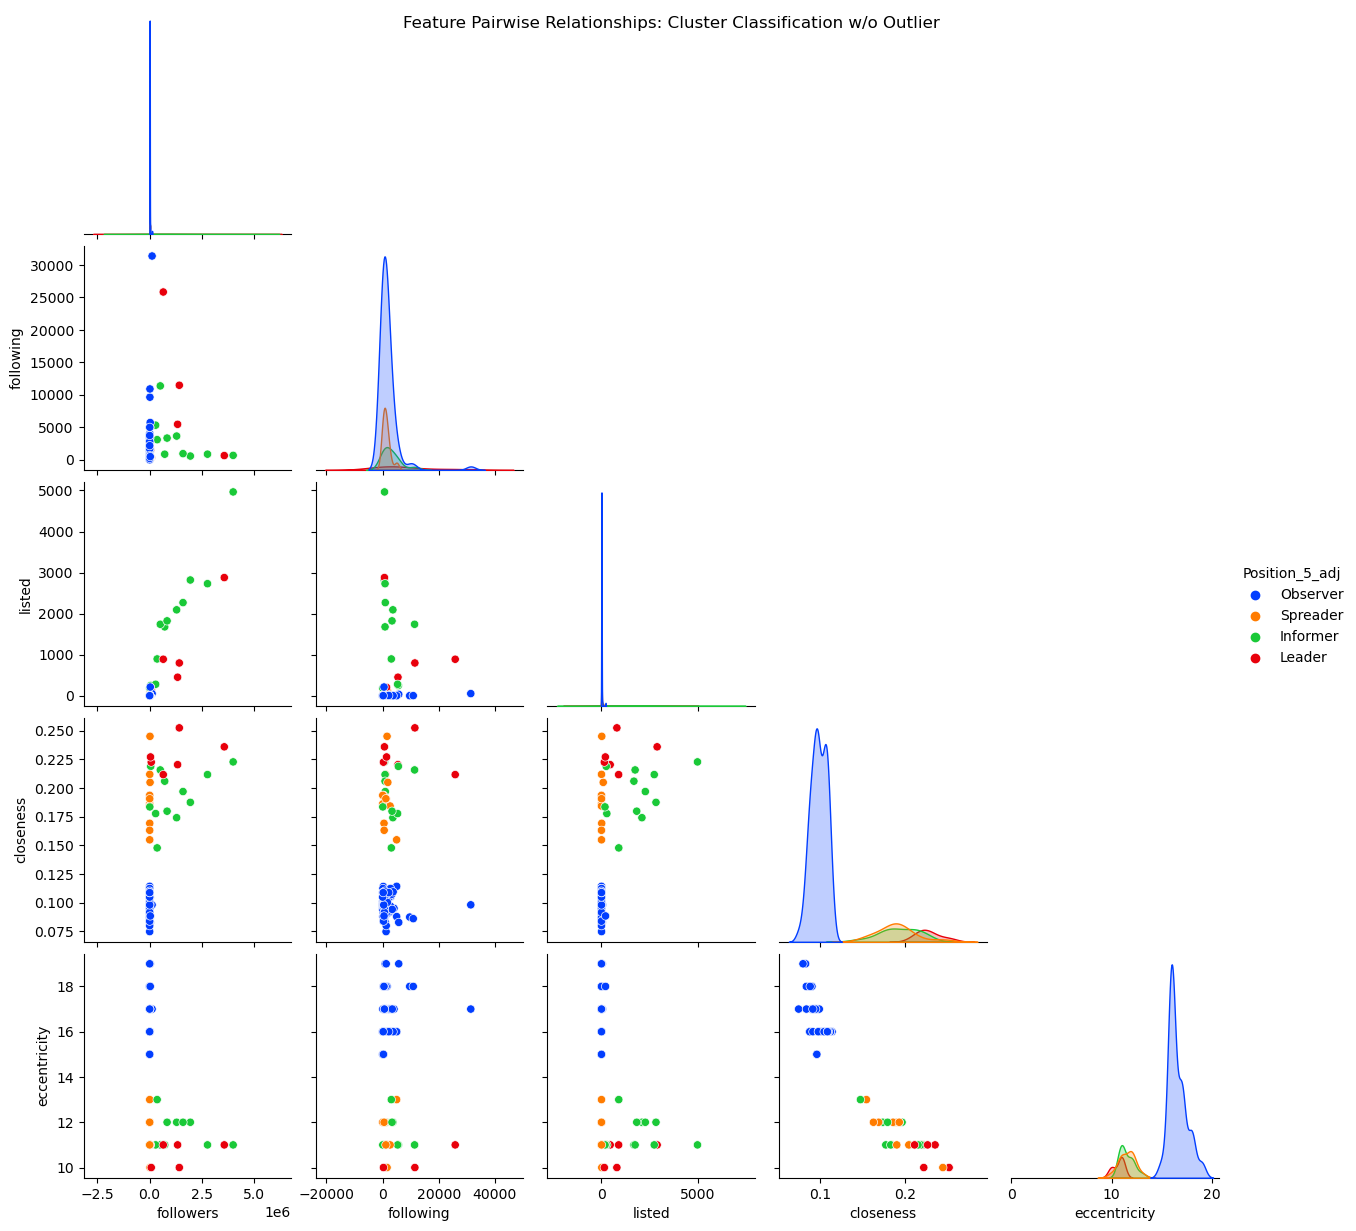

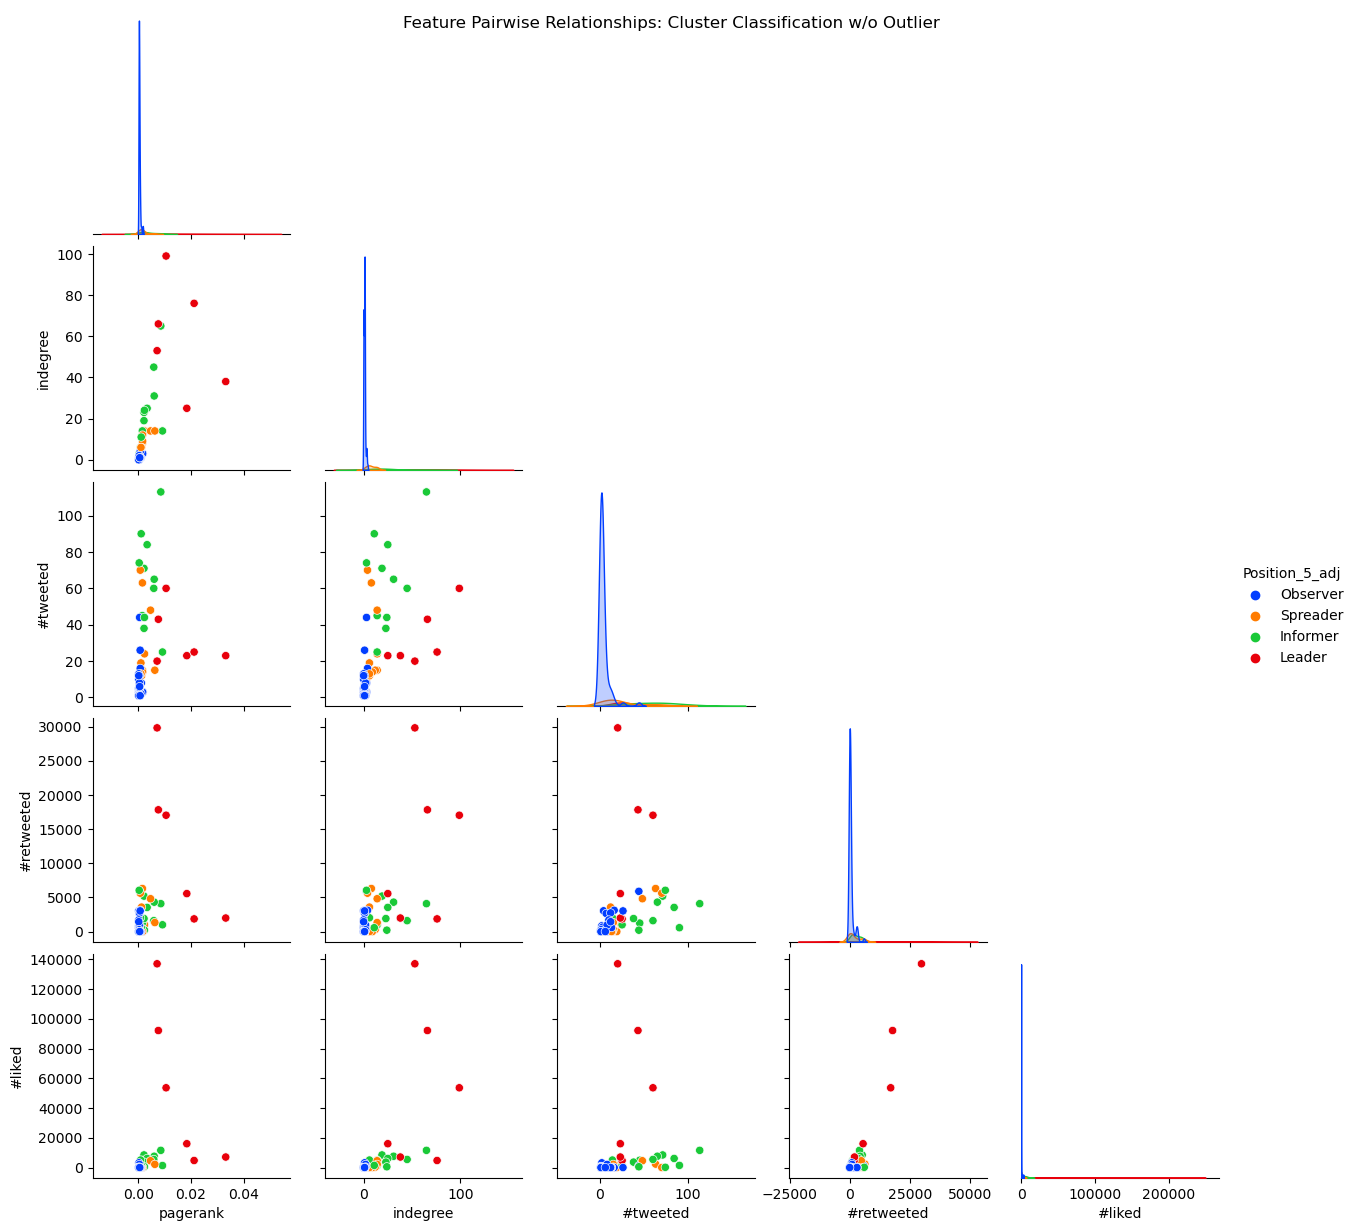

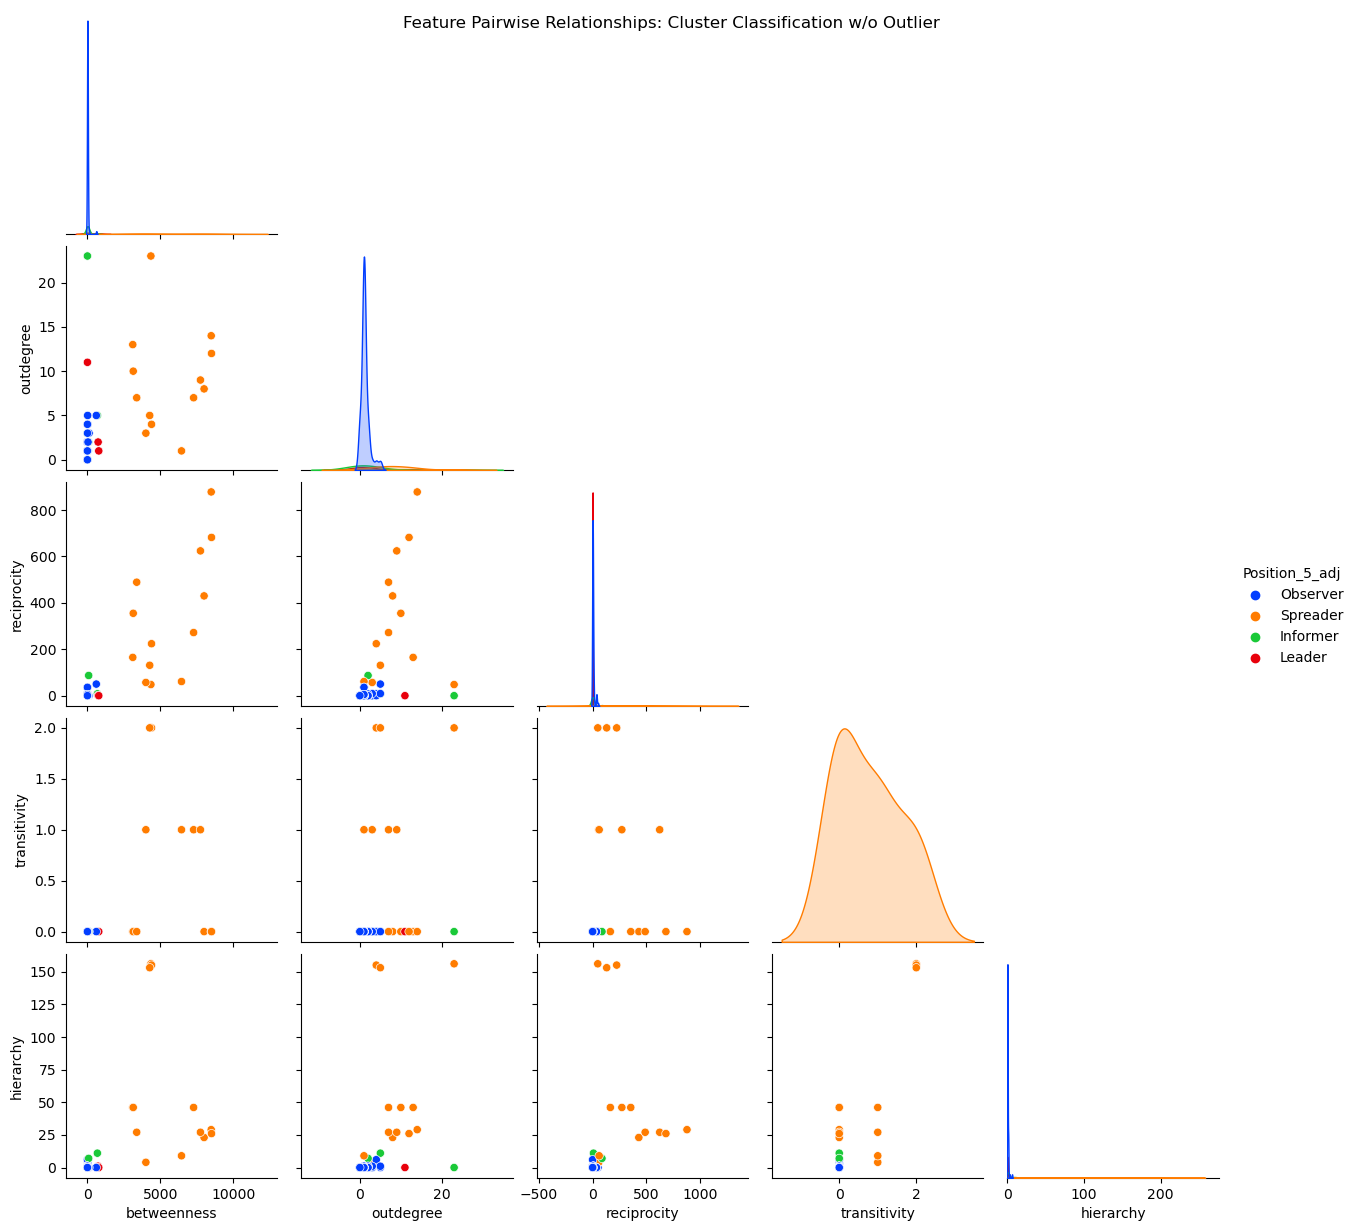

In [16]:
#
# CLUSTER CLASSIFICATION PAIRWISE PLOTS (W/O OUTLIER)
# Activator postion in PutSAFirst is and outlier and distorts the plot.
# Remove Activator for closer look into other cluster relationships.

def cluster_type_5_adj(value):
    #if len(clust_sel) == 2:
    if value == clust_sel[1][0]:
        return "Observer"
    elif value == clust_sel[1][1]:
        return "Spreader"
    elif value == clust_sel[1][2]:
        return "Informer"
    elif value == clust_sel[1][3]:
        return "Leader"
    else:
        return "Minor"

for c in clust_sel:
    if len(c)==4:
        
        df_clust['Position_5_adj'] = df_clust.apply(lambda row: cluster_type_5_adj(row['Cluster']), axis=1)
        clust_role=["Observer","Spreader","Informer","Leader"]

        for k,v in feat_dict.items():

            plt.rcParams["figure.autolayout"] =True
            plt.rcParams["figure.figsize"]=[8,8]
            sns.pairplot(df_clust.loc[df_clust['Cluster'].isin(c)],hue='Position_5_adj',hue_order=clust_role,vars=v,palette=sns.color_palette('bright',len(clust_role)), corner=True)
            plt.suptitle('Feature Pairwise Relationships: Cluster Classification w/o Outlier')
            plt.xlim(left=0)
            #plt.savefig("{}".format(gpath) + x + "_feature_pairwise_3_wr_" + str(k) + ".png")
            #plt.savefig("{}".format(gpath) + x + "_feature_pairwise_3_wr_" + str(k) + ".pdf")
            plt.show()
            #plot_kws={'scatter_kws':{'s':3}}


-------------------------------------------
#### 5. SUMMARY



In this section, I use feature based techniques to conduct analysis on the positions and roles that best describe users in the #Senekal twitter reply network. Below is a summary of notable findings.


I identify 5 distinct clusters that fairly categorise the roles one could expect from a discourse network on a social media platform like Twitter and classify them as such:

1. **Observer** -> periphery users that are far away from the centre of the discourse and have little participation or involvement.


2. **Spreader** -> bridge users that are connected to users in various positions and can easily spread information across the network.


3. **Activator** -> active users that reply to tweets and have a high interaction and engagement with other users.


4. **Informer** -> public users that have many followers, are publicly listed and have a high global tweet count.


5. **Leader** -> popular users that receive many replies to tweets and interact with other important users.

Not surprising, I find members of leading opposition parties assigned to the role of *Leader*, namely: **Our_DA** (DA), **ErnstRoets** (Afriforum), **EFFSouthAfrica** (EFF), **MbuyiseniNdlozi** (EFF) and **Julius_S_Malema** (EFF). 

True to its name, I find the *Informer* role majorly skewed toward journalist and news agency accounts, e.g. **SABCNews**, **eNCA**, **SABreakingNews**, **News24**, and more. 

Finally, I find the twitter account **Tranced6**, which is the only user assigned to the *Activator* role, to exhibit outlier properties accross the *outdegree*, *reciprocity*, *transitivity* and *hierarchy* features. These suggests that users falling within the neighbourhood are prone to replying to each other's tweets at a higher rate, as well as maintaining a consistency in the users they choose to reply to or not reply to. They also tend toward the same hierarchal agreement or consensus on which users they believe to be worth sending their ties to. Consistent with findings from part I, this shows a high probablity of circulation and redundancy of tweets being shared between the same users, thus making them more susceptible to confirmation bias and "groupthink".

In the next section, I simulate multiple diffusion processes using the discourse network to determine whether certain positions in highly clustered communities promote or hinder the spread of information and ideas.



--------
Senekal Positions:



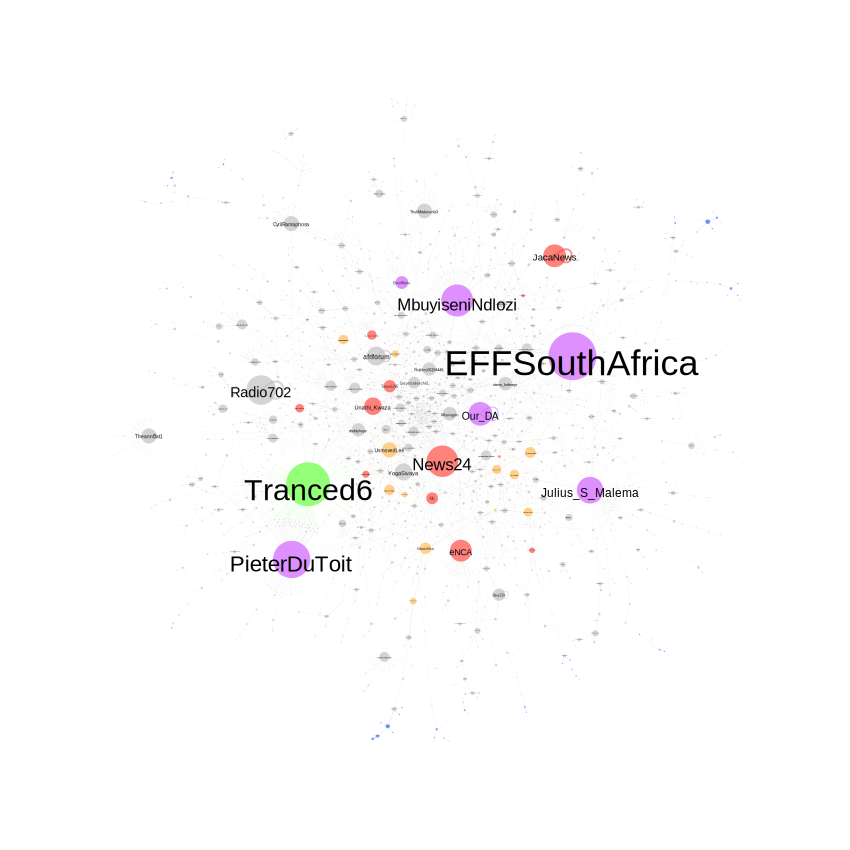

In [17]:
print("\n" + "--------" + "\n" + '\033[1m' + 'Senekal Positions:' + '\033[0m' + "\n")
display(SVG(filename="senekal_kmeans_1.svg"))